In [2]:
from PIL import Image
import requests

from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
#torch.cuda.get_device_properties(0).total_memory

#### Load model

In [5]:
model_name = "llava-hf/llava-1.5-7b-hf"
#model_name = "bczhou/tiny-llava-v1-hf"
#model_name = "unsloth/llava-1.5-7b-hf-bnb-4bit"
#model_name = "liuhaotian/llava-v1.5-7b"

model =  LlavaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name, 
    #torch_dtype=torch.float16, 
    #low_cpu_mem_usage=True,
    #use_flash_attention_2=True
#).to(0)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name,
    #torch_dtype=torch.bfloat16,
    #device_map="cpu",
#)

model.eval()

# load processor
processor = AutoProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

#### Image

In [6]:
# TODO: image and caption from sugarcrepe

#url = "https://www.ilankelman.org/stopsigns/australia.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

# sugarcrepe
image = Image.open("/root/vlm-compositionality/data/raw/coco_val_2017/000000008690.jpg")

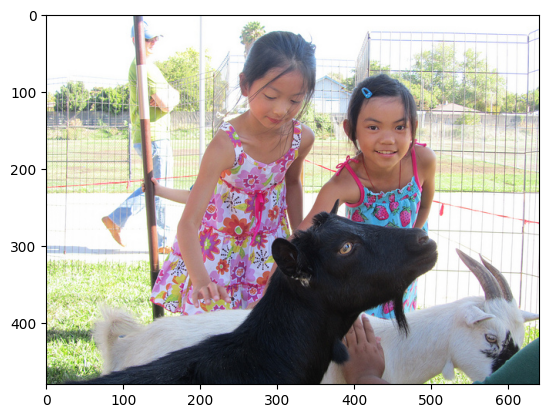

In [8]:
plt.imshow(image)

#### Process image

In [9]:
prompt = "USER: <image>\nDescribe the image. ASSISTANT:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

In [10]:
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


ER:  
Describe the image. ASSISTANT: The image features two young girls standing next to a black goat. They are petting the goat, which is located in the center of the scene. The girls appear to be enjoying their time with the animal.

In the background, there are two other people, one on the left side and the other on the right side of the image. Additionally, there is a chair positioned in the left corner of the scene.


#### Forward pass

In [30]:
# 32+1 layers
# each layer hidden_state -> b x seq_len x embed_dim [ignoring b = 1]

# model.vision_tower = CLIPVisionModel
# model.config.vision_feature_layer = -2

# pixel_values : torch.Size([1, 3, 336, 336])
# patch_embeds: torch.Size([1, 1024, 24, 24])
# patch_embeds flattened : torch.Size([1, 576, 1024])
# embeddings : torch.Size([1, 577, 1024])
# hidden_states : torch.Size([1, 577, 1024])
# hidden_states output -2 layer : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 576, 1024])
# image_features : torch.Size([1, 576, 4096])

In [11]:
output = model(**inputs, output_hidden_states=True)

#### Get softmax scores for layer

In [12]:
image_indices = torch.nonzero((inputs['input_ids'][0] == model.config.image_token_index).long())
image_indices = image_indices.flatten()
reps = torch.vstack(output['hidden_states'])    # 33, 593, 4096

In [13]:
image_reps = torch.index_select(reps, 1, image_indices)
#image_reps = torch.rand(33, 576, 4096).to(torch.bfloat16)

unembed_matrix = model.language_model.lm_head
unembedded_image_reps = unembed_matrix(image_reps)

# scores for all layers
scores = F.softmax(unembedded_image_reps, dim=1)

In [14]:
scores.shape

torch.Size([33, 576, 32064])

#### Get max tokens

In [60]:
max_tokens = torch.argmax(scores, dim=2)
#processor.tokenizer.decode(max_tokens)

In [61]:
max_tokens.shape

torch.Size([33, 576])

#### Map embeddings to image patches

In [ ]:
# How to map patch_embeds to pixel_values?

In [15]:
def internal_confidence_heatmap(tokenizer, scores, object):
    class_token_indices = tokenizer.encode(object)[1:]
    if len(class_token_indices) > 1:
        heatmap = 0
        for index in class_token_indices:
            heatmap += scores[:, :, index]
        return heatmap.T
    else:
        return torch.squeeze(scores[:, :, class_token_indices], dim=2).T

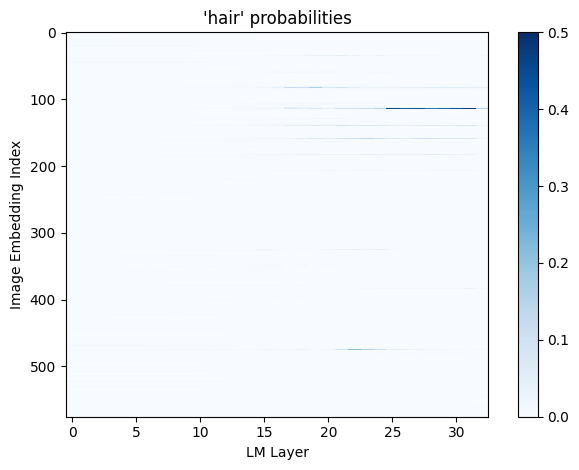

In [16]:
#object = 'tree'
#object = 'car'
#object = 'signs'
#object = 'red'
#object = 'stop'
#object = 'gate'
#object = 'leaves'

# 000000002592.jpg
#object = 'knife'
#object = 'mug'

# 000000008690.jpg
#object = 'goat'
#object = 'girl'
object = 'hair'

heatmap_data = internal_confidence_heatmap(processor.tokenizer, scores, object).detach().cpu().float()
num_image_embeddings = scores.shape[1]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{object}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 0.5)   # 0, 1
plt.colorbar()
plt.show()

In [17]:
def internal_confidence_segmentation(tokenizer, scores, object, num_patches=24):
    class_token_indices = tokenizer.encode(object)[1:]

    if len(class_token_indices) > 1:
        obj_scores = 0
        for index in class_token_indices:
            obj_scores += scores[:, :, index]
    
    else:
        obj_scores = torch.squeeze(scores[:, :, class_token_indices], dim = 2)
        
    max_obj_scores = torch.max(obj_scores, dim=0).values.reshape(num_patches, num_patches).float()
    return max_obj_scores

/tmp/ipykernel_1531/777978903.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))


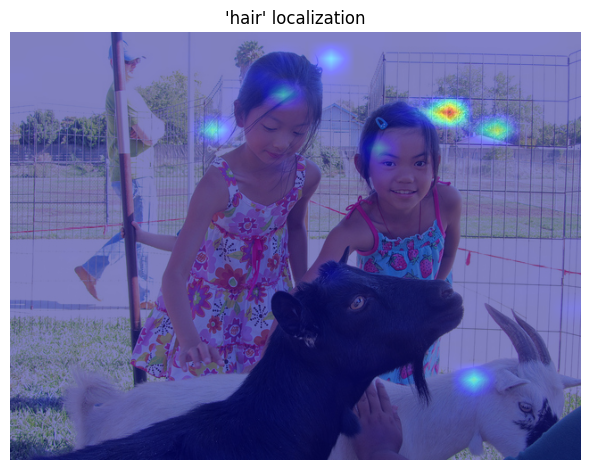

In [18]:
img_width, img_height = image.size

segmentation = internal_confidence_segmentation(processor.tokenizer, scores, object, num_patches=24)
segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))

plt.imshow(image)
plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.title(f"'{object}' localization")
plt.tight_layout()
plt.show()